In [1]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [3]:
# DB Config
uid = "아파트4-103-106"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time
hh_datas

,kw (15min)
Date Time,
2018-05-01 00:00:00,0.099
2018-05-01 00:15:00,0.103
2018-05-01 00:30:00,0.084
2018-05-01 00:45:00,0.079
2018-05-01 01:00:00,0.105
...,...
2019-04-30 22:45:00,0.030
2019-04-30 23:00:00,0.033
2019-04-30 23:15:00,0.038


In [4]:
# Split Data Code
split_datas = round(hh_datas[0::4], 3)

# Merging Data Code
count = 0
merge_datas = pd.DataFrame(columns=['kw (15min)'])
merge_datas['kw (15min)'] = [
    round(hh_datas[
        idx * 4:
        (idx + 1) * 4
    ].mean().values[0], 3)
    for idx in range(0, round(len(hh_datas) / 4))
]
merge_datas.index = [
    hh_datas.index[idx * 4]
    for idx in range(0, round(len(hh_datas) / 4))
]

In [5]:
# training datas 80%
# validation datas 10%
# validation datas 10%
val_days = []
test_days = []

val_data_percentage = 10
test_data_percentage = 10

# Mon.1 ~ Mon.12
for month in range(1,13):
    val_day_list = []
    test_day_list = []
    day_list = list(set(
        split_datas[split_datas.index.month == month].index.day
    ))
    month_datas = split_datas[split_datas.index.month == month].copy()
    start_day = day_list[0]
    end_day = day_list[len(day_list) - 1] + 1
    
    # 10 percentage split
    val_length = round(len(day_list)) / val_data_percentage
    test_length = round(len(day_list)) / test_data_percentage
    
    while True:
        if (len(val_day_list) >= val_length) and \
            (len (test_day_list) >= test_length):
            break
        while True:
            val_day = ran.randrange(start_day, end_day)
            test_day = ran.randrange(start_day, end_day)

            if (val_day != test_day) and \
                (val_day not in val_day_list + test_day_list) and \
                (test_day not in test_day_list + val_day_list):
                val_days.extend(
                    month_datas[
                        month_datas.index.day == val_day
                    ].index
                )
                test_days.extend(
                    month_datas[
                        month_datas.index.day == test_day
                    ].index
                )
                val_day_list.append(val_day)
                test_day_list.append(test_day)
                break;

train_days = split_datas.drop((val_days + test_days)).index

In [6]:
# Set Split Datas
train_split_df = split_datas.loc[train_days].copy()
val_split_df = split_datas.loc[val_days].copy()
test_split_df = split_datas.loc[test_days].copy()

# Set Merge Datas
train_merge_df = merge_datas.loc[train_days].copy()
val_merge_df = merge_datas.loc[val_days].copy()
test_merge_df = merge_datas.loc[test_days].copy()

In [7]:
train_mean = train_split_df.mean()
train_std = train_split_df.std()
print("split data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_split = dict({
    "all": (split_datas - train_mean) / train_std,
    "train": (train_split_df - train_mean) / train_std,
    "val": (val_split_df - train_mean) / train_std,
    "test": (test_split_df - train_mean) / train_std
})

train_mean = train_merge_df.mean()
train_std = train_merge_df.std()
print("merge data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_merge = dict({
    "all": (merge_datas - train_mean) / train_std,
    "train": (train_merge_df - train_mean) / train_std,
    "val": (val_merge_df - train_mean) / train_std,
    "test": (test_merge_df - train_mean) / train_std
})

split data // mean: [0.0978644], std: [0.1005174]
merge data // mean: [0.09744131], std: [0.08338034]


In [8]:
train_mean = train_split_df.mean()
train_std = train_split_df.std()
print("split data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_split = dict({
    "all": (split_datas - train_mean) / train_std,
    "train": (train_split_df - train_mean) / train_std,
    "val": (val_split_df - train_mean) / train_std,
    "test": (test_split_df - train_mean) / train_std
})

train_mean = train_merge_df.mean()
train_std = train_merge_df.std()
print("merge data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_merge = dict({
    "all": (merge_datas - train_mean) / train_std,
    "train": (train_merge_df - train_mean) / train_std,
    "val": (val_merge_df - train_mean) / train_std,
    "test": (test_merge_df - train_mean) / train_std
})

split data // mean: [0.0978644], std: [0.1005174]
merge data // mean: [0.09744131], std: [0.08338034]


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [9]:
windows = dict()

month = [_ for _ in range(1, 13)]
for WINDOW_WIDTH in range(3, 21):
    m_windows = dict()
    for m in month:
        d_windows = []
        days = list(set(norm_split['train'][norm_split['train'].index.month == m].index.day))
        for d in days:
#             print("{} {} window generating!".format(m,d))
            month_datas = norm_split['train'][norm_split['train'].index.month == m]
            # 성능 체크할 때 사용할 것 들
            month_val_datas = norm_split['val'][norm_split['val'].index.month == m]
            month_test_datas = norm_split['test'][norm_split['test'].index.month == m]
            
            day_datas = month_datas[month_datas.index.day == d]
            d_windows.append(
                WindowGenerator(
                    input_width=WINDOW_WIDTH,
                    label_width=1,
                    shift=1,
                    label_columns=['kw (15min)'],
                    train_df=day_datas,
                    val_df=norm_split['val'],
                    test_df=norm_split['test']
                )
            )    
        m_windows['{} month'.format(m)] = d_windows
    windows['{} hours'.format(WINDOW_WIDTH)] = m_windows
print(windows.keys())
print(windows['3 hours'].keys())

dict_keys(['3 hours', '4 hours', '5 hours', '6 hours', '7 hours', '8 hours', '9 hours', '10 hours', '11 hours', '12 hours', '13 hours', '14 hours', '15 hours', '16 hours', '17 hours', '18 hours', '19 hours', '20 hours'])
dict_keys(['1 month', '2 month', '3 month', '4 month', '5 month', '6 month', '7 month', '8 month', '9 month', '10 month', '11 month', '12 month'])


In [10]:
val_performance = dict()
performance = dict()
models = dict()
month = [_ for _ in range(1,13)]
for WINDOW_WIDTH in range(3, 4):
    IPython.display.clear_output()
    key = "{} hours".format(WINDOW_WIDTH)
    print("##### {} training start #####".format(key))

    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    
    for m in month:
        m_key = "{} month".format(m)
        cur_window_month = windows[key][m_key]
        
        for _, cur_window in enumerate(cur_window_month):
            print("#### {} {} training start ####".format(m, _))
            compile_and_fit(lstm_model, cur_window)
    
        if m == 12:
            val_performance[key] = lstm_model.evaluate(
                cur_window.val
            )
            performance[key] = lstm_model.evaluate(
                    cur_window.test
                )
            
    models[key] = lstm_model

##### 3 hours training start #####
#### 1 0 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 2.8742 - mean_absolute_error: 1.0303 - val_loss: 0.9378 - val_mean_absolute_error: 0.5966
Epoch 2/40
1/1 [==============================] - 0s 120ms/step - loss: 2.8479 - mean_absolute_error: 1.0268 - val_loss: 0.9358 - val_mean_absolute_error: 0.5977
Epoch 3/40
1/1 [==============================] - 0s 131ms/step - loss: 2.8223 - mean_absolute_error: 1.0233 - val_loss: 0.9340 - val_mean_absolute_error: 0.5988
Epoch 4/40
1/1 [==============================] - 0s 131ms/step - loss: 2.7976 - mean_absolute_error: 1.0197 - val_loss: 0.9323 - val_mean_absolute_error: 0.6002
Epoch 5/40
1/1 [==============================] - 0s 132ms/step - loss: 2.7736 - mean_absolute_error: 1.0162 - val_loss: 0.9309 - val_mean_absolute_error: 0.6016
Epoch 6/40
1/1 [==============================] - 0s 124ms/step - loss: 2.7504 - mean_absolute_error: 1.0127 - val_loss: 0.9297 -

Epoch 24/40
1/1 [==============================] - 0s 110ms/step - loss: 0.5370 - mean_absolute_error: 0.5358 - val_loss: 0.9463 - val_mean_absolute_error: 0.6808
Epoch 25/40
1/1 [==============================] - 0s 104ms/step - loss: 0.5368 - mean_absolute_error: 0.5357 - val_loss: 0.9461 - val_mean_absolute_error: 0.6804
Epoch 26/40
1/1 [==============================] - 0s 104ms/step - loss: 0.5366 - mean_absolute_error: 0.5356 - val_loss: 0.9459 - val_mean_absolute_error: 0.6801
Epoch 27/40
1/1 [==============================] - 0s 120ms/step - loss: 0.5364 - mean_absolute_error: 0.5355 - val_loss: 0.9457 - val_mean_absolute_error: 0.6797
Epoch 28/40
1/1 [==============================] - 0s 111ms/step - loss: 0.5361 - mean_absolute_error: 0.5354 - val_loss: 0.9455 - val_mean_absolute_error: 0.6794
Epoch 29/40
1/1 [==============================] - 0s 105ms/step - loss: 0.5359 - mean_absolute_error: 0.5353 - val_loss: 0.9453 - val_mean_absolute_error: 0.6791
Epoch 30/40
1/1 [=====

1/1 [==============================] - 0s 111ms/step - loss: 0.2091 - mean_absolute_error: 0.3805 - val_loss: 0.8932 - val_mean_absolute_error: 0.5658
Epoch 5/40
1/1 [==============================] - 0s 116ms/step - loss: 0.2048 - mean_absolute_error: 0.3757 - val_loss: 0.8928 - val_mean_absolute_error: 0.5610
Epoch 6/40
1/1 [==============================] - 0s 143ms/step - loss: 0.2007 - mean_absolute_error: 0.3709 - val_loss: 0.8926 - val_mean_absolute_error: 0.5564
Epoch 7/40
1/1 [==============================] - 0s 117ms/step - loss: 0.1967 - mean_absolute_error: 0.3660 - val_loss: 0.8926 - val_mean_absolute_error: 0.5518
Epoch 8/40
1/1 [==============================] - 0s 108ms/step - loss: 0.1929 - mean_absolute_error: 0.3612 - val_loss: 0.8930 - val_mean_absolute_error: 0.5475
#### 1 22 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.0725 - mean_absolute_error: 0.5825 - val_loss: 0.8935 - val_mean_absolute_error: 0.5434
Epoch 2/40
1

Epoch 2/40
1/1 [==============================] - 0s 125ms/step - loss: 0.0316 - mean_absolute_error: 0.1528 - val_loss: 0.9561 - val_mean_absolute_error: 0.4949
Epoch 3/40
1/1 [==============================] - 0s 110ms/step - loss: 0.0304 - mean_absolute_error: 0.1501 - val_loss: 0.9585 - val_mean_absolute_error: 0.4951
#### 2 19 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0355 - mean_absolute_error: 0.1564 - val_loss: 0.9598 - val_mean_absolute_error: 0.4946
Epoch 2/40
1/1 [==============================] - 0s 143ms/step - loss: 0.0343 - mean_absolute_error: 0.1530 - val_loss: 0.9611 - val_mean_absolute_error: 0.4942
Epoch 3/40
1/1 [==============================] - 0s 118ms/step - loss: 0.0331 - mean_absolute_error: 0.1498 - val_loss: 0.9624 - val_mean_absolute_error: 0.4939
#### 2 20 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0235 - mean_absolute_error: 0.1263 - val_loss: 0.9639 - val_me

Epoch 12/40
1/1 [==============================] - 0s 109ms/step - loss: 0.1338 - mean_absolute_error: 0.2685 - val_loss: 0.9441 - val_mean_absolute_error: 0.4992
Epoch 13/40
1/1 [==============================] - 0s 98ms/step - loss: 0.1336 - mean_absolute_error: 0.2689 - val_loss: 0.9432 - val_mean_absolute_error: 0.4989
Epoch 14/40
1/1 [==============================] - 0s 100ms/step - loss: 0.1334 - mean_absolute_error: 0.2691 - val_loss: 0.9426 - val_mean_absolute_error: 0.4985
Epoch 15/40
1/1 [==============================] - 0s 100ms/step - loss: 0.1332 - mean_absolute_error: 0.2690 - val_loss: 0.9422 - val_mean_absolute_error: 0.4981
Epoch 16/40
1/1 [==============================] - 0s 104ms/step - loss: 0.1329 - mean_absolute_error: 0.2687 - val_loss: 0.9421 - val_mean_absolute_error: 0.4975
Epoch 17/40
1/1 [==============================] - 0s 107ms/step - loss: 0.1327 - mean_absolute_error: 0.2683 - val_loss: 0.9422 - val_mean_absolute_error: 0.4970
Epoch 18/40
1/1 [======

Epoch 2/40
1/1 [==============================] - 0s 125ms/step - loss: 3.1010 - mean_absolute_error: 1.1900 - val_loss: 0.9009 - val_mean_absolute_error: 0.5628
Epoch 3/40
1/1 [==============================] - 0s 112ms/step - loss: 3.0833 - mean_absolute_error: 1.1902 - val_loss: 0.9017 - val_mean_absolute_error: 0.5654
#### 3 11 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 3.0099 - mean_absolute_error: 1.0964 - val_loss: 0.9024 - val_mean_absolute_error: 0.5686
Epoch 2/40
1/1 [==============================] - 0s 102ms/step - loss: 2.9915 - mean_absolute_error: 1.0958 - val_loss: 0.9032 - val_mean_absolute_error: 0.5718
Epoch 3/40
1/1 [==============================] - 0s 108ms/step - loss: 2.9734 - mean_absolute_error: 1.0951 - val_loss: 0.9041 - val_mean_absolute_error: 0.5751
#### 3 12 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1694 - mean_absolute_error: 0.3946 - val_loss: 0.9036 - val_me

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.8018 - mean_absolute_error: 0.9334 - val_loss: 0.9000 - val_mean_absolute_error: 0.5776
Epoch 2/40
1/1 [==============================] - 0s 101ms/step - loss: 1.7960 - mean_absolute_error: 0.9318 - val_loss: 0.9001 - val_mean_absolute_error: 0.5776
Epoch 3/40
1/1 [==============================] - 0s 160ms/step - loss: 1.7904 - mean_absolute_error: 0.9303 - val_loss: 0.9004 - val_mean_absolute_error: 0.5777
#### 3 21 training start ####
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2481 - mean_absolute_error: 0.4599 - val_loss: 0.8997 - val_mean_absolute_error: 0.5731
Epoch 2/40
1/1 [==============================] - 0s 108ms/step - loss: 0.2357 - mean_absolute_error: 0.4461 - val_loss: 0.8992 - val_mean_absolute_error: 0.5685
Epoch 3/40
1/1 [==============================] - 0s 117ms/step - loss: 0.2236 - mean_absolute_error: 0.4320 - val_loss: 0.8989 - val_mean_absolute_error: 0.5640
Epoc

Epoch 11/40
1/1 [==============================] - 0s 103ms/step - loss: 1.1344 - mean_absolute_error: 0.4853 - val_loss: 0.9188 - val_mean_absolute_error: 0.5030
Epoch 12/40
1/1 [==============================] - 0s 103ms/step - loss: 1.1324 - mean_absolute_error: 0.4922 - val_loss: 0.9168 - val_mean_absolute_error: 0.5051
Epoch 13/40
1/1 [==============================] - 0s 100ms/step - loss: 1.1306 - mean_absolute_error: 0.4991 - val_loss: 0.9150 - val_mean_absolute_error: 0.5071
Epoch 14/40
1/1 [==============================] - 0s 105ms/step - loss: 1.1290 - mean_absolute_error: 0.5053 - val_loss: 0.9134 - val_mean_absolute_error: 0.5091
Epoch 15/40
1/1 [==============================] - 0s 105ms/step - loss: 1.1275 - mean_absolute_error: 0.5109 - val_loss: 0.9120 - val_mean_absolute_error: 0.5110
Epoch 16/40
1/1 [==============================] - 0s 107ms/step - loss: 1.1262 - mean_absolute_error: 0.5158 - val_loss: 0.9108 - val_mean_absolute_error: 0.5127
Epoch 17/40
1/1 [=====

1/1 [==============================] - 0s 105ms/step - loss: 0.3210 - mean_absolute_error: 0.4374 - val_loss: 0.9082 - val_mean_absolute_error: 0.5889
Epoch 4/40
1/1 [==============================] - 0s 109ms/step - loss: 0.3187 - mean_absolute_error: 0.4342 - val_loss: 0.9076 - val_mean_absolute_error: 0.5855
Epoch 5/40
1/1 [==============================] - 0s 102ms/step - loss: 0.3166 - mean_absolute_error: 0.4310 - val_loss: 0.9071 - val_mean_absolute_error: 0.5822
Epoch 6/40
1/1 [==============================] - 0s 104ms/step - loss: 0.3146 - mean_absolute_error: 0.4279 - val_loss: 0.9067 - val_mean_absolute_error: 0.5789
Epoch 7/40
1/1 [==============================] - 0s 101ms/step - loss: 0.3127 - mean_absolute_error: 0.4248 - val_loss: 0.9064 - val_mean_absolute_error: 0.5758
Epoch 8/40
1/1 [==============================] - 0s 154ms/step - loss: 0.3110 - mean_absolute_error: 0.4218 - val_loss: 0.9062 - val_mean_absolute_error: 0.5728
Epoch 9/40
1/1 [=======================

1/1 [==============================] - 0s 126ms/step - loss: 0.7473 - mean_absolute_error: 0.6293 - val_loss: 0.8961 - val_mean_absolute_error: 0.5581
Epoch 8/40
1/1 [==============================] - 0s 115ms/step - loss: 0.7461 - mean_absolute_error: 0.6272 - val_loss: 0.8962 - val_mean_absolute_error: 0.5569
Epoch 9/40
1/1 [==============================] - 0s 125ms/step - loss: 0.7450 - mean_absolute_error: 0.6254 - val_loss: 0.8964 - val_mean_absolute_error: 0.5559
#### 5 21 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3070 - mean_absolute_error: 0.7150 - val_loss: 0.8974 - val_mean_absolute_error: 0.5602
Epoch 2/40
1/1 [==============================] - 0s 139ms/step - loss: 1.3028 - mean_absolute_error: 0.7180 - val_loss: 0.8985 - val_mean_absolute_error: 0.5645
Epoch 3/40
1/1 [==============================] - 0s 130ms/step - loss: 1.2987 - mean_absolute_error: 0.7209 - val_loss: 0.8999 - val_mean_absolute_error: 0.5689
#### 5 22 tr

1/1 [==============================] - 0s 101ms/step - loss: 0.8626 - mean_absolute_error: 0.5992 - val_loss: 0.8955 - val_mean_absolute_error: 0.5677
Epoch 14/40
1/1 [==============================] - 0s 99ms/step - loss: 0.8596 - mean_absolute_error: 0.6008 - val_loss: 0.8956 - val_mean_absolute_error: 0.5701
#### 6 8 training start ####
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 2.2364 - mean_absolute_error: 0.7523 - val_loss: 0.8968 - val_mean_absolute_error: 0.5744
Epoch 2/40
1/1 [==============================] - 0s 112ms/step - loss: 2.2317 - mean_absolute_error: 0.7549 - val_loss: 0.8982 - val_mean_absolute_error: 0.5786
Epoch 3/40
1/1 [==============================] - 0s 106ms/step - loss: 2.2272 - mean_absolute_error: 0.7574 - val_loss: 0.8997 - val_mean_absolute_error: 0.5829
#### 6 9 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.0037 - mean_absolute_error: 0.5530 - val_loss: 0.8986 - val_mean_absolute_e

Epoch 2/40
1/1 [==============================] - 0s 123ms/step - loss: 0.2321 - mean_absolute_error: 0.3382 - val_loss: 0.8982 - val_mean_absolute_error: 0.5249
Epoch 3/40
1/1 [==============================] - 0s 113ms/step - loss: 0.2306 - mean_absolute_error: 0.3349 - val_loss: 0.8993 - val_mean_absolute_error: 0.5212
#### 7 2 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3177 - mean_absolute_error: 0.4146 - val_loss: 0.8995 - val_mean_absolute_error: 0.5235
Epoch 2/40
1/1 [==============================] - 0s 125ms/step - loss: 0.3163 - mean_absolute_error: 0.4153 - val_loss: 0.9000 - val_mean_absolute_error: 0.5259
Epoch 3/40
1/1 [==============================] - 0s 109ms/step - loss: 0.3150 - mean_absolute_error: 0.4159 - val_loss: 0.9007 - val_mean_absolute_error: 0.5279
#### 7 3 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6718 - mean_absolute_error: 0.5351 - val_loss: 0.9016 - val_mean

Epoch 2/40
1/1 [==============================] - 0s 99ms/step - loss: 2.6530 - mean_absolute_error: 0.8889 - val_loss: 0.9096 - val_mean_absolute_error: 0.5973
Epoch 3/40
1/1 [==============================] - 0s 108ms/step - loss: 2.6441 - mean_absolute_error: 0.8901 - val_loss: 0.9124 - val_mean_absolute_error: 0.6031
#### 7 12 training start ####
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0982 - mean_absolute_error: 0.6447 - val_loss: 0.9150 - val_mean_absolute_error: 0.6088
Epoch 2/40
1/1 [==============================] - 0s 99ms/step - loss: 1.0953 - mean_absolute_error: 0.6470 - val_loss: 0.9177 - val_mean_absolute_error: 0.6146
Epoch 3/40
1/1 [==============================] - 0s 112ms/step - loss: 1.0926 - mean_absolute_error: 0.6493 - val_loss: 0.9207 - val_mean_absolute_error: 0.6203
#### 7 13 training start ####
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8202 - mean_absolute_error: 0.5989 - val_loss: 0.9206 - val_mean

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0941 - mean_absolute_error: 0.2554 - val_loss: 0.9180 - val_mean_absolute_error: 0.5199
Epoch 2/40
1/1 [==============================] - 0s 126ms/step - loss: 0.0912 - mean_absolute_error: 0.2506 - val_loss: 0.9209 - val_mean_absolute_error: 0.5183
Epoch 3/40
1/1 [==============================] - 0s 118ms/step - loss: 0.0887 - mean_absolute_error: 0.2466 - val_loss: 0.9234 - val_mean_absolute_error: 0.5167
#### 8 8 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0694 - mean_absolute_error: 0.2162 - val_loss: 0.9243 - val_mean_absolute_error: 0.5145
Epoch 2/40
1/1 [==============================] - 0s 109ms/step - loss: 0.0674 - mean_absolute_error: 0.2125 - val_loss: 0.9250 - val_mean_absolute_error: 0.5125
Epoch 3/40
1/1 [==============================] - 0s 120ms/step - loss: 0.0655 - mean_absolute_error: 0.2089 - val_loss: 0.9256 - val_mean_absolute_error: 0.5104
#### 

Epoch 6/40
1/1 [==============================] - 0s 100ms/step - loss: 0.2754 - mean_absolute_error: 0.4057 - val_loss: 0.9117 - val_mean_absolute_error: 0.5331
Epoch 7/40
1/1 [==============================] - 0s 98ms/step - loss: 0.2749 - mean_absolute_error: 0.4067 - val_loss: 0.9113 - val_mean_absolute_error: 0.5331
Epoch 8/40
1/1 [==============================] - 0s 100ms/step - loss: 0.2744 - mean_absolute_error: 0.4073 - val_loss: 0.9112 - val_mean_absolute_error: 0.5328
Epoch 9/40
1/1 [==============================] - 0s 102ms/step - loss: 0.2739 - mean_absolute_error: 0.4075 - val_loss: 0.9112 - val_mean_absolute_error: 0.5320
Epoch 10/40
1/1 [==============================] - 0s 105ms/step - loss: 0.2734 - mean_absolute_error: 0.4073 - val_loss: 0.9114 - val_mean_absolute_error: 0.5310
#### 8 18 training start ####
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.2843 - mean_absolute_error: 0.5998 - val_loss: 0.9114 - val_mean_absolute_error: 0.5360
E

Epoch 4/40
1/1 [==============================] - 0s 119ms/step - loss: 0.2622 - mean_absolute_error: 0.4117 - val_loss: 0.9357 - val_mean_absolute_error: 0.5450
#### 9 6 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2442 - mean_absolute_error: 0.3716 - val_loss: 0.9359 - val_mean_absolute_error: 0.5397
Epoch 2/40
1/1 [==============================] - 0s 104ms/step - loss: 0.2398 - mean_absolute_error: 0.3624 - val_loss: 0.9365 - val_mean_absolute_error: 0.5345
Epoch 3/40
1/1 [==============================] - 0s 112ms/step - loss: 0.2358 - mean_absolute_error: 0.3543 - val_loss: 0.9375 - val_mean_absolute_error: 0.5295
#### 9 7 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5419 - mean_absolute_error: 0.5062 - val_loss: 0.9375 - val_mean_absolute_error: 0.5348
Epoch 2/40
1/1 [==============================] - 0s 105ms/step - loss: 0.5381 - mean_absolute_error: 0.5069 - val_loss: 0.9379 - val_mean

#### 9 10 training start ####
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2872 - mean_absolute_error: 0.3812 - val_loss: 0.9032 - val_mean_absolute_error: 0.5568
Epoch 2/40
1/1 [==============================] - 0s 104ms/step - loss: 0.2825 - mean_absolute_error: 0.3763 - val_loss: 0.9030 - val_mean_absolute_error: 0.5535
Epoch 3/40
1/1 [==============================] - 0s 104ms/step - loss: 0.2782 - mean_absolute_error: 0.3736 - val_loss: 0.9030 - val_mean_absolute_error: 0.5505
Epoch 4/40
1/1 [==============================] - 0s 105ms/step - loss: 0.2742 - mean_absolute_error: 0.3737 - val_loss: 0.9032 - val_mean_absolute_error: 0.5476
Epoch 5/40
1/1 [==============================] - 0s 101ms/step - loss: 0.2706 - mean_absolute_error: 0.3738 - val_loss: 0.9036 - val_mean_absolute_error: 0.5450
#### 9 11 training start ####
Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: 0.5202 - mean_absolute_error: 0.4892 - val_loss: 0.9042 - val_me

1/1 [==============================] - 0s 112ms/step - loss: 0.5006 - mean_absolute_error: 0.5263 - val_loss: 0.9021 - val_mean_absolute_error: 0.5556
#### 10 6 training start ####
Epoch 1/40
1/1 [==============================] - 15s 15s/step - loss: 1.4267 - mean_absolute_error: 0.8455 - val_loss: 0.9028 - val_mean_absolute_error: 0.5624
Epoch 2/40
1/1 [==============================] - 2s 2s/step - loss: 1.4194 - mean_absolute_error: 0.8482 - val_loss: 0.9039 - val_mean_absolute_error: 0.5694
Epoch 3/40
1/1 [==============================] - 2s 2s/step - loss: 1.4126 - mean_absolute_error: 0.8509 - val_loss: 0.9055 - val_mean_absolute_error: 0.5765
#### 10 7 training start ####
Epoch 1/40
1/1 [==============================] - 6479s 6479s/step - loss: 0.6598 - mean_absolute_error: 0.5723 - val_loss: 0.9063 - val_mean_absolute_error: 0.5736
Epoch 2/40
1/1 [==============================] - 0s 135ms/step - loss: 0.6565 - mean_absolute_error: 0.5688 - val_loss: 0.9073 - val_mean_absolu

1/1 [==============================] - 2s 2s/step - loss: 0.5752 - mean_absolute_error: 0.5608 - val_loss: 0.9074 - val_mean_absolute_error: 0.5874
Epoch 2/40
1/1 [==============================] - 0s 153ms/step - loss: 0.5697 - mean_absolute_error: 0.5546 - val_loss: 0.9075 - val_mean_absolute_error: 0.5846
Epoch 3/40
1/1 [==============================] - 0s 175ms/step - loss: 0.5644 - mean_absolute_error: 0.5484 - val_loss: 0.9077 - val_mean_absolute_error: 0.5820
#### 11 3 training start ####
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 2.7706 - mean_absolute_error: 0.8670 - val_loss: 0.9085 - val_mean_absolute_error: 0.5878
Epoch 2/40
1/1 [==============================] - 0s 174ms/step - loss: 2.7613 - mean_absolute_error: 0.8661 - val_loss: 0.9096 - val_mean_absolute_error: 0.5937
Epoch 3/40
1/1 [==============================] - 0s 152ms/step - loss: 2.7525 - mean_absolute_error: 0.8652 - val_loss: 0.9110 - val_mean_absolute_error: 0.5998
#### 11 4 train

Epoch 4/40
1/1 [==============================] - 0s 123ms/step - loss: 1.8705 - mean_absolute_error: 0.7283 - val_loss: 0.9151 - val_mean_absolute_error: 0.6072
Epoch 5/40
1/1 [==============================] - 0s 111ms/step - loss: 1.8647 - mean_absolute_error: 0.7232 - val_loss: 0.9134 - val_mean_absolute_error: 0.6045
Epoch 6/40
1/1 [==============================] - 0s 114ms/step - loss: 1.8591 - mean_absolute_error: 0.7182 - val_loss: 0.9118 - val_mean_absolute_error: 0.6019
Epoch 7/40
1/1 [==============================] - 0s 114ms/step - loss: 1.8536 - mean_absolute_error: 0.7132 - val_loss: 0.9105 - val_mean_absolute_error: 0.5996
Epoch 8/40
1/1 [==============================] - 0s 110ms/step - loss: 1.8482 - mean_absolute_error: 0.7084 - val_loss: 0.9094 - val_mean_absolute_error: 0.5975
Epoch 9/40
1/1 [==============================] - 0s 121ms/step - loss: 1.8430 - mean_absolute_error: 0.7038 - val_loss: 0.9086 - val_mean_absolute_error: 0.5957
Epoch 10/40
1/1 [===========

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1964 - mean_absolute_error: 0.3960 - val_loss: 0.9243 - val_mean_absolute_error: 0.6437
Epoch 2/40
1/1 [==============================] - 0s 111ms/step - loss: 0.1884 - mean_absolute_error: 0.3887 - val_loss: 0.9202 - val_mean_absolute_error: 0.6370
Epoch 3/40
1/1 [==============================] - 0s 106ms/step - loss: 0.1811 - mean_absolute_error: 0.3817 - val_loss: 0.9166 - val_mean_absolute_error: 0.6305
Epoch 4/40
1/1 [==============================] - 0s 108ms/step - loss: 0.1744 - mean_absolute_error: 0.3753 - val_loss: 0.9133 - val_mean_absolute_error: 0.6241
Epoch 5/40
1/1 [==============================] - 0s 109ms/step - loss: 0.1682 - mean_absolute_error: 0.3690 - val_loss: 0.9104 - val_mean_absolute_error: 0.6179
Epoch 6/40
1/1 [==============================] - 0s 109ms/step - loss: 0.1627 - mean_absolute_error: 0.3628 - val_loss: 0.9079 - val_mean_absolute_error: 0.6119
Epoch 7/40
1/1 [===============

1/1 [==============================] - 0s 105ms/step - loss: 0.9004 - mean_absolute_error: 0.7699 - val_loss: 0.9081 - val_mean_absolute_error: 0.6107
Epoch 20/40
1/1 [==============================] - 0s 108ms/step - loss: 0.8987 - mean_absolute_error: 0.7665 - val_loss: 0.9071 - val_mean_absolute_error: 0.6075
Epoch 21/40
1/1 [==============================] - 0s 109ms/step - loss: 0.8971 - mean_absolute_error: 0.7634 - val_loss: 0.9063 - val_mean_absolute_error: 0.6045
Epoch 22/40
1/1 [==============================] - 0s 110ms/step - loss: 0.8955 - mean_absolute_error: 0.7604 - val_loss: 0.9056 - val_mean_absolute_error: 0.6017
Epoch 23/40
1/1 [==============================] - 0s 111ms/step - loss: 0.8941 - mean_absolute_error: 0.7576 - val_loss: 0.9050 - val_mean_absolute_error: 0.5992
Epoch 24/40
1/1 [==============================] - 0s 112ms/step - loss: 0.8927 - mean_absolute_error: 0.7549 - val_loss: 0.9045 - val_mean_absolute_error: 0.5970
Epoch 25/40
1/1 [=================

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

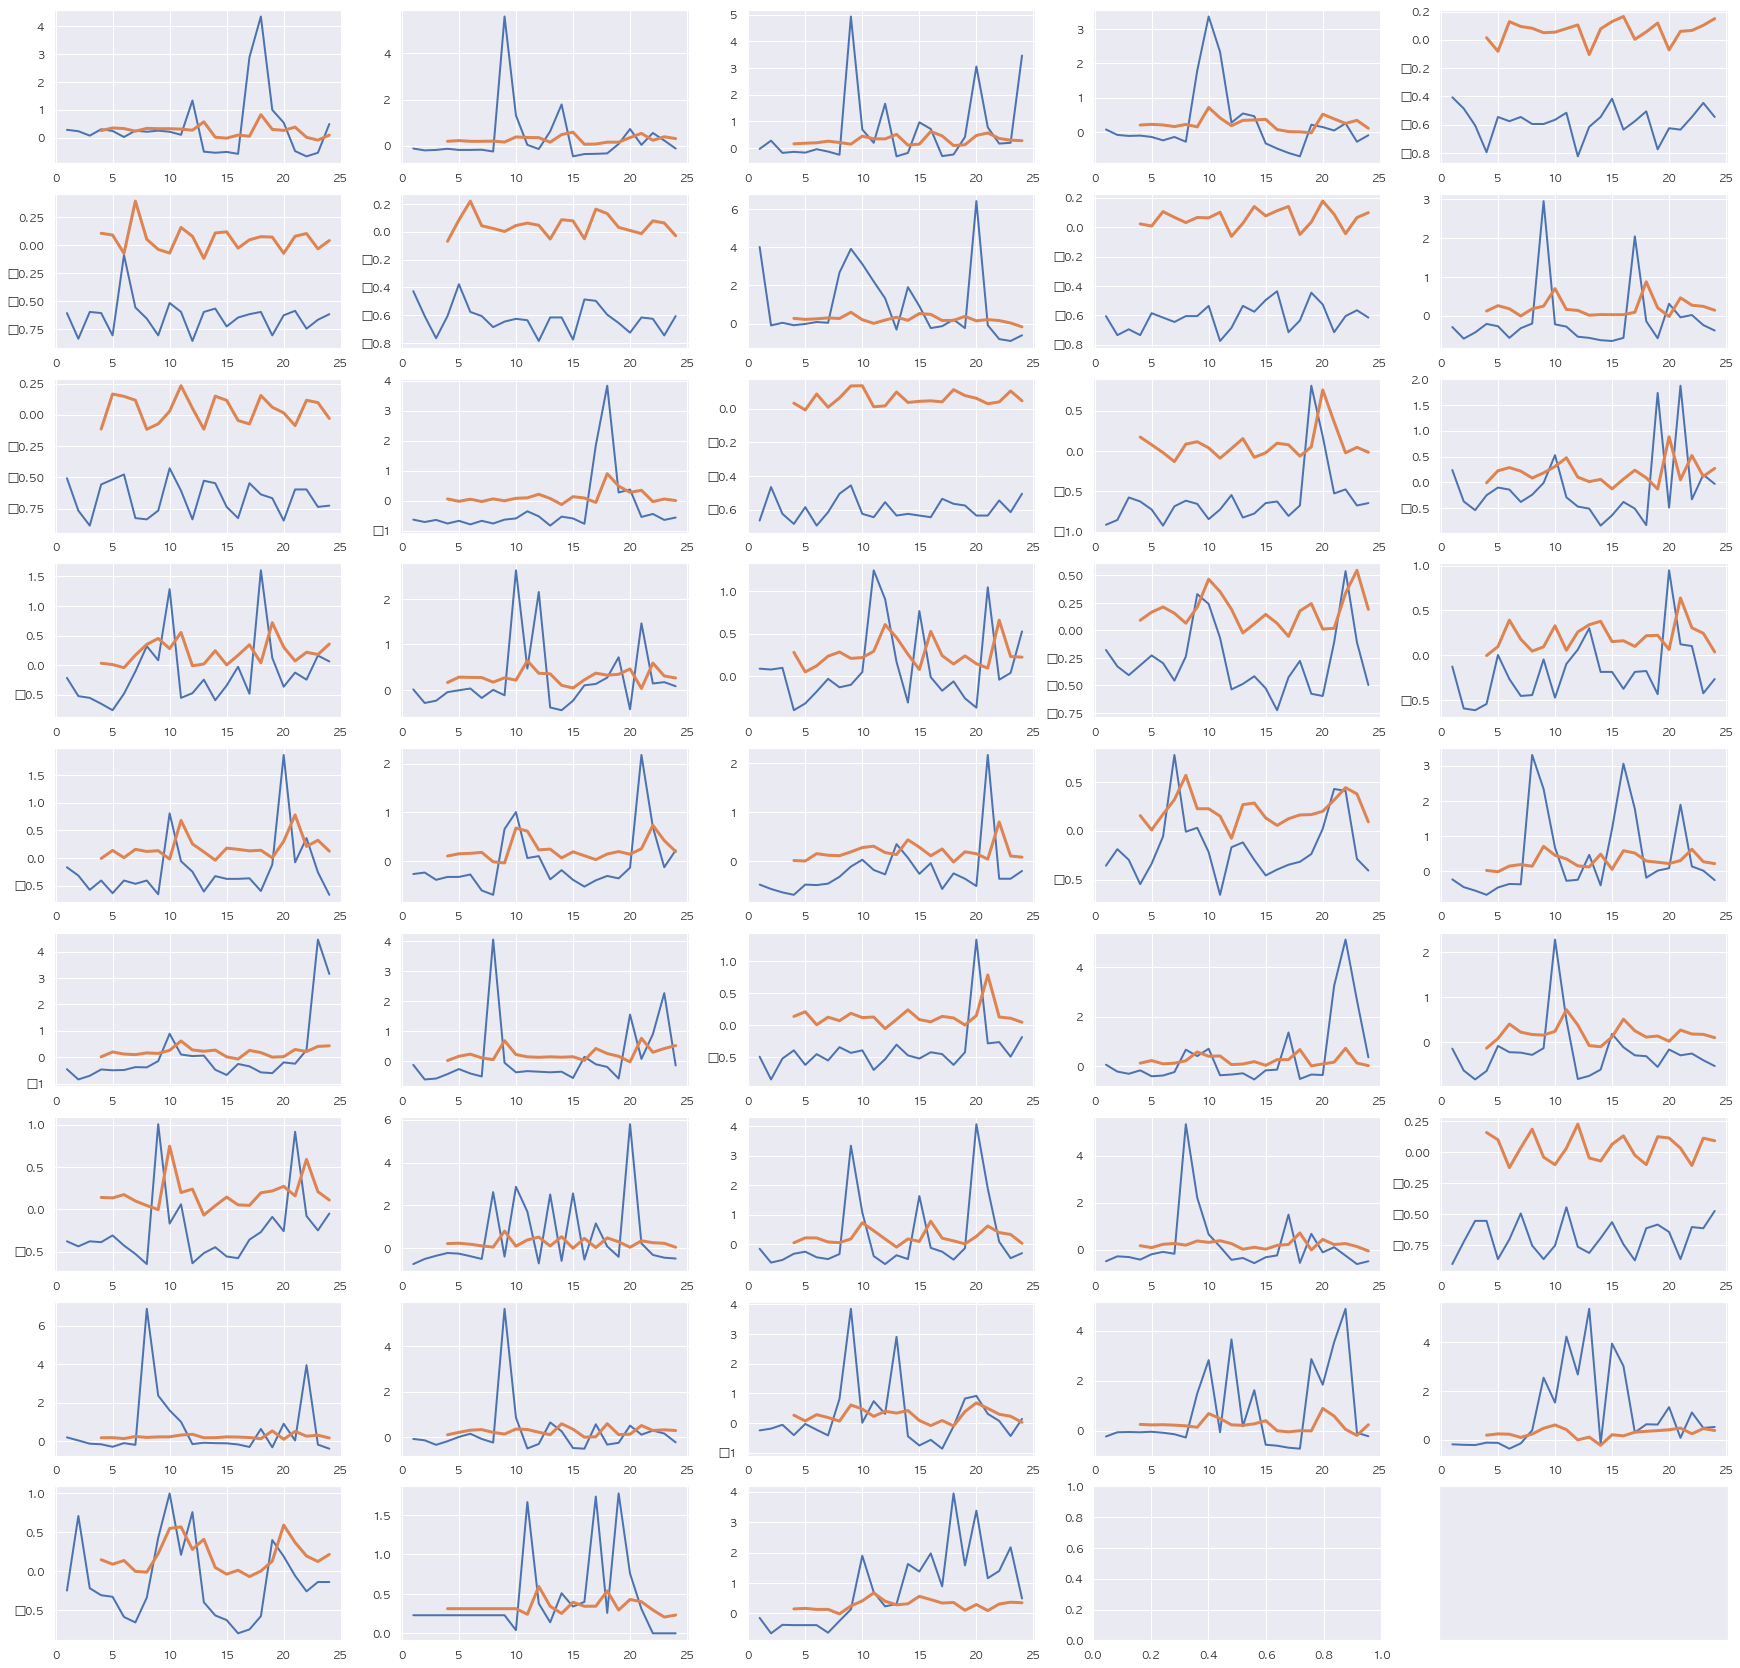

In [11]:
predict_data_length = 3
WINDOW_WIDTH = 3
fig, axes = plt.subplots(math.ceil(round(len(norm_split['test']) / 24) / 5),5, figsize=(30,30))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cnt = 0

for split in range(0, round(len(norm_split['test'])), 24):
    key = "{} hours".format(WINDOW_WIDTH)

    original_x_labels = [idx for idx in range(1,25)]
    predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
    original = norm_split['test'][split:(split + 24)].values.flatten()
    predicts = []
    inputs = []

    for idx in range(0, (24 - predict_data_length)):
        inputs = norm_split['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
        inputs = inputs.reshape(-1, predict_data_length,1)
        result = models[key](inputs).numpy().flatten()[2]

        predicts.append(result)
        inputs = np.append(inputs.flatten()[1:predict_data_length],result)

    sns.lineplot(original_x_labels, original, lw=2, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
    sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
        
    cnt += 1      

In [3]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

predict_data_length = 3
WINDOW_WIDTH = 3
cnt = 0

evaluater = pd.DataFrame(columns=['mean dis', 'mean sim'])

for WINDOW_WIDTH in range(3, 4):
    print("WINDOW_WIDTH: {}".format(WINDOW_WIDTH))
    distances = np.array([])
    similarities = np.array([])
    for split in range(0, round(len(norm_split['test'])), 24):
        key = "{} hours".format(WINDOW_WIDTH)

        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = norm_split['test'][split:(split + 24)].values.flatten()
        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = norm_split['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
            inputs = inputs.reshape(-1,predict_data_length,1)
            result = models[key](inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)

        distances = np.append(distances, euc(original[predict_data_length:], predicts))
        similarities = np.append(similarities, cos_sim(original[predict_data_length:], predicts))
        cnt += 1
    evaluater.loc[key] = [distances.mean(), similarities.mean()]
        
evaluater

WINDOW_WIDTH: 3


NameError: name 'split_sets' is not defined

In [ ]:
evaluater